# Plotting the predictions of the single- and multi-center RPN signatures
- This jupyter notebook is available on-line at:
  - https://github.com/spisakt/RPN-signature/blob/master/notebooks/3_compare_predictions.ipynb
- Input data for the notebook and non-standard code (PAINTeR library) is available in the repo:
  - https://github.com/spisakt/RPN-signature
- Raw MRI-data from study-centers 1 and 2 are available on OpenNeuro:
  - https://openneuro.org/datasets/ds002608/versions/1.0.1
  - https://openneuro.org/datasets/ds002609/versions/1.0.3
- Raw data from center 3 is available upon reasonable request.

## Imports

In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn.connectome import vec_to_sym_matrix, sym_matrix_to_vec
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from mlxtend.evaluate import permutation_test
from scipy.stats import f_oneway

import sys
sys.path.append('../')
from PAINTeR import plot # in-house lib used for the RPN-signature

## Load and merge behavioral data for all three centers (after exclusions)

In [2]:
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()
y = df.mean_QST_pain_sensitivity

## Load predictions for the original single-center and the newly proposed multi-center model

In [3]:
# predictions
multicener_predictions = np.genfromtxt('../res/multi-center/nested_cv_pred_full_GroupKFold30.csv', delimiter=',')
rpn_predictions = np.hstack((df_bochum.nested_prediction,
                            df_essen.prediction,
                            df_szeged.prediction))

predictions = {
    'single-center' : rpn_predictions,
    'multi-center' : multicener_predictions
}

### create study masks

In [4]:
study_masks = {
    "study 1" : (df.study == 'bochum').values,
    "study 2" : (df.study == 'essen').values,
    "study 3" : (df.study == 'szeged').values,
    "study 1+2+3" : np.array([True] * len(y))
}

## Observed vs. Predicted plots

*** single-center study 1 ****************************************************
R=0.45
p_corr=0.00363
MSE=0.43
MSE=0.46
Expl. Var. =0.185
*** single-center study 2 ****************************************************
R=0.43
p_corr=0.00325
MSE=0.54
MSE=0.59
Expl. Var. =0.181
*** single-center study 3 ****************************************************
R=0.47
p_corr=0.02300
MSE=0.44
MSE=0.57
Expl. Var. =0.170
*** single-center study 1+2+3 ****************************************************
R=0.42
p_corr=0.00013
MSE=0.47
MSE=0.54
Expl. Var. =0.164
*** multi-center study 1 ****************************************************
R=0.61
p_corr=0.00025
MSE=0.35
MSE=0.45
Expl. Var. =0.343
*** multi-center study 2 ****************************************************
R=0.59
p_corr=0.00000
MSE=0.42
MSE=0.54
Expl. Var. =0.340
*** multi-center study 3 ****************************************************
R=0.51
p_corr=0.01250
MSE=0.22
MSE=0.37
Expl. Var. =0.262
*** multi-center study 1+2+3 ***********

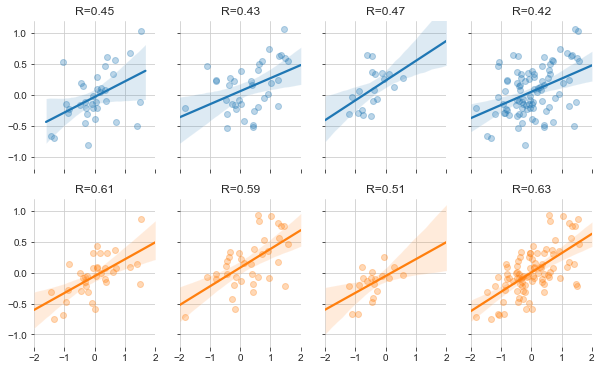

In [5]:
sns.set_style('ticks')
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(10,6), sharex=True, sharey=True)

cols = ['tab:blue', 'tab:orange']

for row, cv in enumerate(predictions.keys()):
    for col, study in enumerate(study_masks.keys()):
        g=sns.regplot(y[study_masks[study]], predictions[cv][study_masks[study]], ax=axs[row, col],
                    scatter=True, scatter_kws={'alpha':0.3}, color=cols[row])
        g.set(xlabel=None) 
        axs[row, col].set_xlim([-2, 2])
        axs[row, col].set_ylim([-1.2, 1.2])
        axs[row, col].spines['top'].set_visible(False)
        axs[row, col].spines['bottom'].set_visible(False)
        axs[row, col].spines['right'].set_visible(False)
        axs[row, col].spines['left'].set_visible(False)
        axs[row, col].grid(True)
        
        print('***', cv, study, '****************************************************')
                   
        corr = np.corrcoef(y[study_masks[study]], predictions[cv][study_masks[study]])[0,1]
        axs[row, col].title.set_text("R={:.2f}".format(corr))
        print("R={:.2f}".format(corr))
        
        # takes some seconds
        p_corr = permutation_test(y[study_masks[study]], predictions[cv][study_masks[study]],
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
        print("p_corr={:.5f}".format(p_corr))
        
        mse = mean_squared_error(y[study_masks[study]], predictions[cv][study_masks[study]])
        print("MSE={:.2f}".format(mse))
        
        mae = mean_absolute_error(y[study_masks[study]], predictions[cv][study_masks[study]])
        print("MSE={:.2f}".format(mae))
        
        expvar = explained_variance_score(y[study_masks[study]], predictions[cv][study_masks[study]])
        print("Expl. Var. ={:.3f}".format(expvar))
   
   
        
plt.savefig('../res/multi-center/regplots_obs-pred.pdf')  

## Violoin plots per center for the observed and predicted values

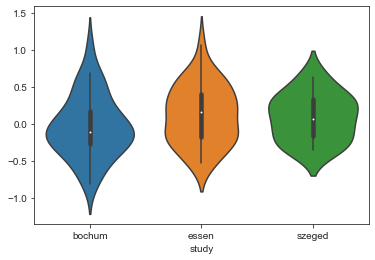

In [6]:
sns.violinplot(data=df, x='study', y=predictions['single-center'])

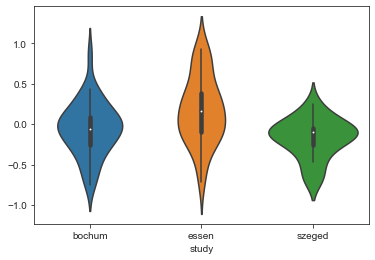

In [7]:
sns.violinplot(data=df, x='study', y=predictions['multi-center'])

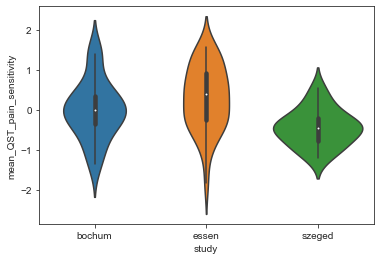

In [8]:
sns.violinplot(data=df, x='study', y='mean_QST_pain_sensitivity')

In [9]:
print(df.mean_QST_pain_sensitivity[df.study=='bochum'].mean())
print(df.mean_QST_pain_sensitivity[df.study=='essen'].mean())
print(df.mean_QST_pain_sensitivity[df.study=='szeged'].mean())

f_oneway(df.mean_QST_pain_sensitivity[df.study=='bochum'],
        df.mean_QST_pain_sensitivity[df.study=='essen'],
        df.mean_QST_pain_sensitivity[df.study=='szeged'])

0.00855140388857826
0.289473414953464
-0.435775823593041


F_onewayResult(statistic=6.505541599574436, pvalue=0.00231739640326624)

## Predicted vs. Predicted plot

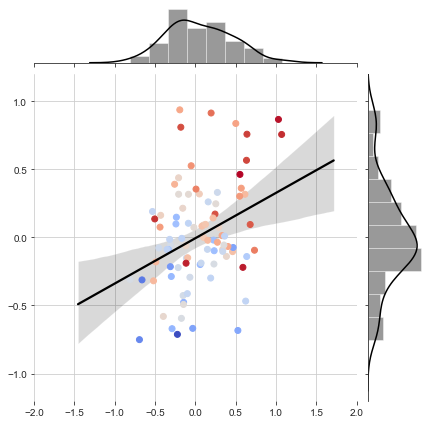

In [10]:
g=sns.jointplot(predictions['single-center'], predictions['multi-center'], kind='reg', color='black', scatter = False )
g.ax_joint.scatter(predictions['single-center'],predictions['multi-center'], c=df.mean_QST_pain_sensitivity,
                   cmap="coolwarm")
g.fig.set_size_inches(6,6)
g.ax_joint.set(xlabel=None) 
g.ax_joint.set_xlim([-2, 2])
g.ax_joint.set_ylim([-1.2, 1.2])
g.ax_joint.spines['top'].set_visible(False)
g.ax_joint.spines['bottom'].set_visible(False)
g.ax_joint.spines['right'].set_visible(False)
g.ax_joint.spines['left'].set_visible(False)
g.ax_joint.grid(True)
plt.savefig('../res/multi-center/regplots_pred-pred.pdf')  

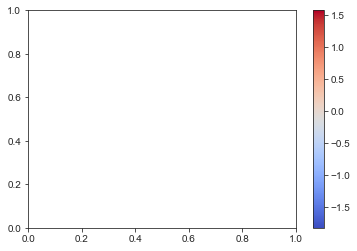

In [11]:
norm = plt.Normalize(df.mean_QST_pain_sensitivity.min(), df.mean_QST_pain_sensitivity.max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
plt.colorbar(sm)
plt.savefig('../res/multi-center/regplots_pred-pred_colorbar.pdf')  

In [12]:
corr = np.corrcoef(predictions['single-center'], predictions['multi-center'])[0,1]
print("R={:.2f}".format(corr))
        
# takes some seconds
p_corr = permutation_test(y[study_masks[study]], predictions[cv][study_masks[study]],
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
print("p_corr={:.5f}".format(p_corr))

R=0.35
p_corr=0.00000
